## **Restaurant Review Insights: Combining Word Cloud Visualization and LSTM/GRU Models**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
import nltk
import spacy #load spacy

# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])  # Disable components we don't need
print(nlp.pipe_names)

# data import
df = pd.read_csv('restaurant_reviews_az.csv')
df


C:\Users\hankc\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,IVS7do_HBzroiCiymNdxDg,fdFgZQQYQJeEAshH4lxSfQ,sGy67CpJctjeCWClWqonjA,3,1,1,0,"OK, the hype about having Hatch chili in your ...",2020-01-27 22:59:06
1,QP2pSzSqpJTMWOCuUuyXkQ,JBLWSXBTKFvJYYiM-FnCOQ,3w7NRntdQ9h0KwDsksIt5Q,5,1,1,1,Pandemic pit stop to have an ice cream.... onl...,2020-04-19 05:33:16
2,oK0cGYStgDOusZKz9B1qug,2_9fKnXChUjC5xArfF8BLg,OMnPtRGmbY8qH_wIILfYKA,5,1,0,0,I was lucky enough to go to the soft opening a...,2020-02-29 19:43:44
3,E_ABvFCNVLbfOgRg3Pv1KQ,9MExTQ76GSKhxSWnTS901g,V9XlikTxq0My4gE8LULsjw,5,0,0,0,I've gone to claim Jumpers all over the US and...,2020-03-14 21:47:07
4,Rd222CrrnXkXukR2iWj69g,LPxuausjvDN88uPr-Q4cQA,CA5BOxKRDPGJgdUQ8OUOpw,4,1,0,0,"If you haven't been to Maynard's kitchen, it'...",2020-01-17 20:32:57
...,...,...,...,...,...,...,...,...,...
48142,C0uxsLrbiwQ8a6S9P3bj2A,IVm1abIK9OWCsrkmEAM7iQ,kldw3rf8_T6J2LxsetQ5UA,4,1,0,0,"Wow, there are a lot of 1 star reviews for thi...",2021-11-21 00:16:31
48143,Zu4ng3tjf_2oa9LlnEvUmQ,ItQzeC91hJF6qvvE7-OZmQ,Yzh7Xo1_JBDWUl2BzRiYaQ,5,0,0,0,"Fresh and delicious food, served fast. What mo...",2021-10-30 20:17:34
48144,jacDcaIWSPdZq2bDq1GD_g,Y-mwrjOx29pnJX0MCBb2Yg,9VRmMY9vGhGKGz9hiGoEUw,1,0,0,0,If I could leave no stars I would. I understan...,2021-11-28 14:23:39
48145,dkGbETTcSQZTwHSnAMnLUw,_RmG_5kxRPgTWP7RptaFgQ,Bq0CQcwk5R8yhm-MGfHxCA,5,6,2,4,Bosnian food?? \n\n--- location. This is a HID...,2020-01-05 04:20:42


In [2]:
# Remove the unnecessary columns
df = df.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool','date'], axis=1)
df


,stars,text
0,3,"OK, the hype about having Hatch chili in your ..."
1,5,Pandemic pit stop to have an ice cream.... onl...
2,5,I was lucky enough to go to the soft opening a...
3,5,I've gone to claim Jumpers all over the US and...
4,4,"If you haven't been to Maynard's kitchen, it'..."
...,...,...
48142,4,"Wow, there are a lot of 1 star reviews for thi..."
48143,5,"Fresh and delicious food, served fast. What mo..."
48144,1,If I could leave no stars I would. I understan...
48145,5,Bosnian food?? \n\n--- location. This is a HID...


In [3]:
# Remove 3 star reviews from the input data, create a new column - Sentiment for the remaining reviews.
# For reviews with 1 or 2 star rating, set the value in the Sentiment column to 0. 
# For reviews with 4 or 5 star rating, set the value in the sentiment column to 1. 

df = df[df['stars'] != 3]

# Create Sentiment column
df['Sentiment'] = df['stars'].apply(lambda x: 0 if x in [1, 2] else 1)
df = df.sample(n=20000, random_state=42)
df


C:\Users\hankc\AppData\Local\Temp\ipykernel_2780\3107812766.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['stars'].apply(lambda x: 0 if x in [1, 2] else 1)


,stars,text,Sentiment
27942,4,Love the gaudiness of this place and their hig...,1
33680,2,Called back to back for about 10 mins and no o...,0
7792,2,"Driving by Tucson on our way to Phoenix, and w...",0
21713,5,My best friend and I love to eat here :D yummy...,1
33008,5,Got my food immediately and it was pretty dang...,1
...,...,...,...
44282,1,Absolute WORST service I've ever had in my LIF...,0
38439,5,We recently visited PY Steakhouse this past we...,1
38344,5,Visited Tucson couple months ago for the weeke...,1
34244,1,"I was ignored for 10 minutes, and then the sta...",0


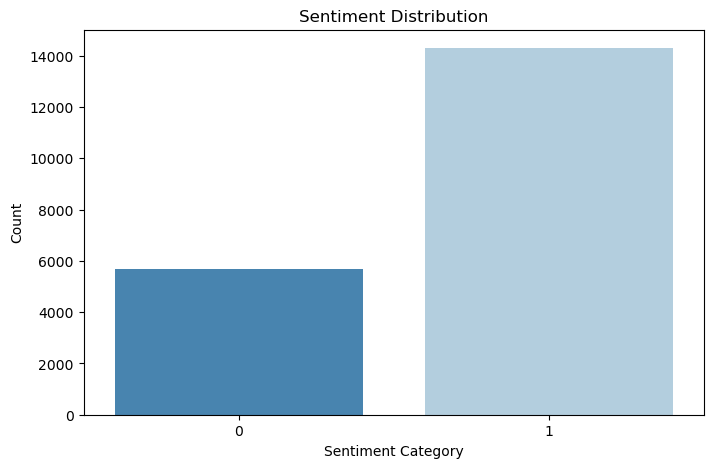

In [4]:
# Count the occurrences of each sentiment category
sentiment_counts = df['Sentiment'].value_counts()

# Set the figure size
plt.figure(figsize=(8, 5))

# Create a bar plot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Blues_r")

# Add labels and title
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Sentiment Distribution")

plt.show()


### **Functions for Text Processing**

- **`normalize_single_review(doc, lowercase=True, remove_stopwords=True)`**: 
  - **This function processes a single review by lemmatizing the text. It optionally converts the text to lowercase and removes stopwords, depending on the provided parameters.**
  
- **`process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True)`**:
  - **This function processes the dataset in chunks for efficiency. It splits the dataset into smaller chunks and applies the `normalize_single_review` function to each chunk using spaCy's `pipe` method to speed up processing. The function also allows for customization of chunk size, batch size, and text normalization options.**

In [5]:
from tqdm import tqdm

# Define a function to process a single review
def normalize_single_review(doc, lowercase=True, remove_stopwords=True):
    lemmatized = []
    for token in doc:
        lemma = token.lemma_.lower() if lowercase else token.lemma_
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(lemma)
    return " ".join(lemmatized)

# Process the dataset in chunks
def process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True):
    results = []

    for i in tqdm(range(0, len(df), chunk_size)):  # Loop through the dataset in chunks
        chunk = df['text'].iloc[i:i+chunk_size].tolist()

        # Process each chunk using spaCy's pipe for efficiency
        processed_chunk = []
        for doc in nlp.pipe(chunk, batch_size=batch_size, n_process=1):  # Use a limited number of processes
            processed_chunk.append(normalize_single_review(doc, lowercase=lowercase, remove_stopwords=remove_stopwords))

        results.extend(processed_chunk)  # Add the processed chunk to results

    return results
    

### **Methods from NLTK**

- **`alpha_num(text)`**: **Removes non-alphanumeric characters from the text, keeping only letters, numbers, and spaces.**
  
- **`remove_URL(text)`**: **Removes URLs from the text using a regular expression to match and replace both `http` and `https` links.**

- **`remove_html(text)`**: **Removes HTML tags from the text using a regular expression to match and replace any content within `< >` brackets.**


In [6]:
# to remove non alphanumeric character
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
    

In [7]:
# Apply preprocessing steps
df['text'] = df['text'].apply(remove_URL)
print("remove_URL function done")
df['text'] = df['text'].apply(remove_html)
print("remove_html function done")
df['text'] = df['text'].apply(alpha_num)
print("alpha_num function done")

# Apply the chunked processing to the entire dataframe
df['text'] = process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True)
 

remove_URL function done
remove_html function done
alpha_num function done


100%|██████████| 20/20 [02:52<00:00,  8.63s/it]


<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Generate a word cloud displaying the 10 most frequent nouns, verbs, and adjectives from reviews with a sentiment of 0.</b>
</h>

In [8]:
# Initialize the lists for nouns, verbs, and adjectives
nouns = []
verbs = []
adjectives = []

# Filter the rows with Sentiment 0
filtered_df = df[df['Sentiment'] == 0]

# Loop through the filtered rows
for doc in nlp.pipe(filtered_df['text']):
  for token in doc:
    if token.pos_ == 'VERB':
      verbs.append(token.lemma_)
    if token.pos_ == 'NOUN':
      nouns.append(token.lemma_)
    if token.pos_ == 'ADJ':  
      adjectives.append(token.lemma_)

from collections import Counter

noun_counter = Counter(nouns)
verb_counter = Counter(verbs)
adjective_counter = Counter(adjectives)
 

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Top 10 Nouns Used in Dataset</b>
</h>

7748
[('order', 5421),
 ('food', 4477),
 ('time', 2917),
 ('place', 2205),
 ('service', 2068),
 ('minute', 1634),
 ('restaurant', 1406),
 ('customer', 1341),
 ('table', 1254),
 ('people', 904)]


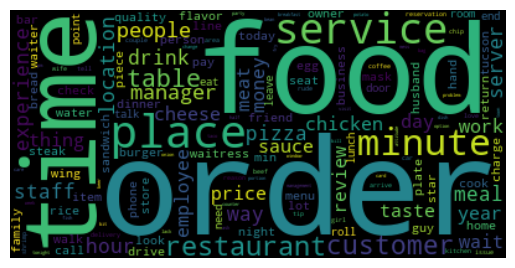

In [9]:
import pprint

print(len(noun_counter))
pprint.pprint(noun_counter.most_common(10))

!pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(noun_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Top 10 Verbs Used in Dataset</b>
</h>

2066
[('come', 2347),
 ('go', 2145),
 ('get', 2078),
 ('say', 1758),
 ('ask', 1582),
 ('wait', 1475),
 ('eat', 1229),
 ('tell', 1223),
 ('want', 1170),
 ('try', 1103)]


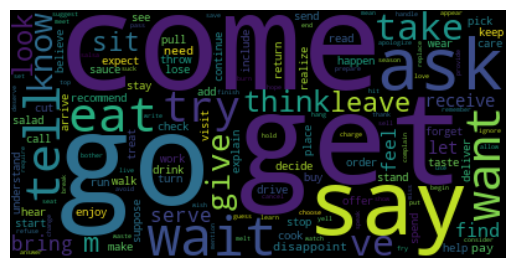

In [10]:
print(len(verb_counter))
pprint.pprint(verb_counter.most_common(10))

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(verb_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Top 10 Adjectives Used in Dataset</b>
</h>

3210
[('good', 1948),
 ('bad', 1450),
 ('great', 627),
 ('cold', 527),
 ('horrible', 450),
 ('close', 431),
 ('small', 426),
 ('long', 422),
 ('terrible', 420),
 ('little', 420)]


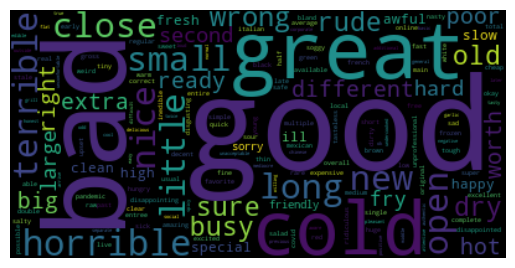

In [11]:
print(len(adjective_counter))
pprint.pprint(adjective_counter.most_common(10))

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(adjective_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Prepare the training and test datasets for deep learning classification on the data.</b>
</h>

In [12]:
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df['text'], df['Sentiment'], test_size=0.2, random_state=5, 
                                                                              stratify=df['Sentiment'])


<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Prepare the text data for deep learning models by converting the text into sequences of integers and ensuring that the vocabulary is properly sized and indexed.</b>
</h>

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model Parameters
embedding_dim = 100  # Size of the word embedding vectors
max_length = 100  # Maximum length of input sequences (for padding/truncation)
trunc_type = 'post'  # Truncate sequences from the end if they exceed max_length
padding_type = 'post'  # Pad sequences at the end if they are shorter than max_length

# Define Vocabulary Size
vocab_size = 20000  # Limit vocabulary size to 20,000 words
oov_token = "<OOV>"  # Token for out-of-vocabulary words (OOV handling)

# Create a TextVectorization Layer
vectorizer = TextVectorization(
    max_tokens=vocab_size,  # Define vocabulary size
    output_mode="int"  # Convert words into integer sequences
)

# Adapt the vectorizer to the training dataset (build vocabulary from training sentences)
vectorizer.adapt(train_sentences)

train_sequences = vectorizer(tf.constant(train_sentences))
test_sequences = vectorizer(tf.constant(test_sentences))

# Retrieve vocabulary and create a word index mapping (word → integer ID)
vocab = vectorizer.get_vocabulary()
word_index = {word: idx for idx, word in enumerate(vocab)}

# Get the actual vocabulary size (including OOV and mask tokens)
vocab_size = vectorizer.vocabulary_size()
print("Vocabulary size including optional mask and OOV indices is: ", vocab_size)

Vocabulary size including optional mask and OOV indices is:  20000


<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>After converting the text data into integer sequences, we pad the sequences to ensure that all input sequences have the same length. This step is essential for deep learning models, as they require fixed-length inputs.
</b>
</h>

In [14]:
# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# convert validation dataset to sequence and pad sequences
test_sequences = vectorizer(tf.constant(test_sentences))
test_padded = pad_sequences(test_sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Next, we load pre-trained GloVe (Global Vectors for Word Representation) embeddings to represent words as vectors. GloVe embeddings are widely used in NLP models as they capture semantic relationships between words.
</b>
</h>

In [15]:
# Define the path to the pre-trained GloVe embeddings file
EMBEDDING_FILE = 'glove.6B.100d.txt'  # Change file name if using a different GloVe version

# Initialize an empty dictionary to store word embeddings
word_vectors = {}

# Open the GloVe file and read the embeddings
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()  # Split each line into word + embedding values
        word = values[0]  # The first value in the line is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The remaining values are the embedding coefficients
        word_vectors[word] = coefs  # Store the word and its corresponding embedding in the dictionary

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Then, we create an embedding matrix to store the word embeddings for all the words in our vocabulary. This matrix will be used in the deep learning model for embedding lookups.
</b>
</h>

In [16]:
# Initialize an embedding matrix with zeros
# Shape: (vocab_size + 1, embedding_dim)
#   - vocab_size + 1: Extra row for padding index (zero index)
#   - embedding_dim: Each word vector's dimension (e.g., 100 for GloVe 100D)
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Iterate over the word_index dictionary (word → integer mapping)
for word, i in word_index.items():
    # Retrieve the pre-trained embedding vector for the word
    embedding_vector = word_vectors.get(word)
    # If the word exists in GloVe embeddings, store its vector in the matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Assign the vector to its corresponding index

# **Model Training: Bidirectional GRU - Concatenation**

In [17]:
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

#  Define Input Layer
input_layer = Input(shape=(max_length,))  # Input is a sequence of word indices

# Embedding Layer with Pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (same as GloVe)
    input_length=max_length,        # Maximum sequence length
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Keep embeddings frozen (set True for fine-tuning)
)(input_layer)

#  First Bidirectional GRU Layer (returning sequences)
bigru_layer_1 = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)

#  Second Bidirectional GRU Layer (outputs a single vector)
bigru_layer_2 = Bidirectional(GRU(32))(bigru_layer_1)

# Fully Connected Layers
dense_layer = Dense(64, activation='relu')(bigru_layer_2)
dropout_layer = Dropout(0.5)(dense_layer)  # Dropout to reduce overfitting

# Output Layer for Binary Classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Define the Functional Model
bigru_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#  Compile the Model
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Print Model Summary
bigru_model.summary()

C:\Users\hankc\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,173 (8.01 MB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Stop training when a monitored metric has stopped improving
</b>
</h>

In [18]:
from keras.callbacks import EarlyStopping
#fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = bigru_model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.7929 - loss: 0.4424 - val_accuracy: 0.9271 - val_loss: 0.1955
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9235 - loss: 0.2071 - val_accuracy: 0.9325 - val_loss: 0.1711
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.9398 - loss: 0.1604 - val_accuracy: 0.9379 - val_loss: 0.1689
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9464 - loss: 0.1455 - val_accuracy: 0.9454 - val_loss: 0.1530
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.9535 - loss: 0.1245 - val_accuracy: 0.9444 - val_loss: 0.1559
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.9599 - loss: 0.1049 - val_accuracy: 0.9385 - val_loss: 0.2098
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.9722 - loss: 0.0779 - val_accuracy: 0.9427 - val_loss: 0.1944
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9805 - loss: 0.0607 - 

# **Model Evaluation**

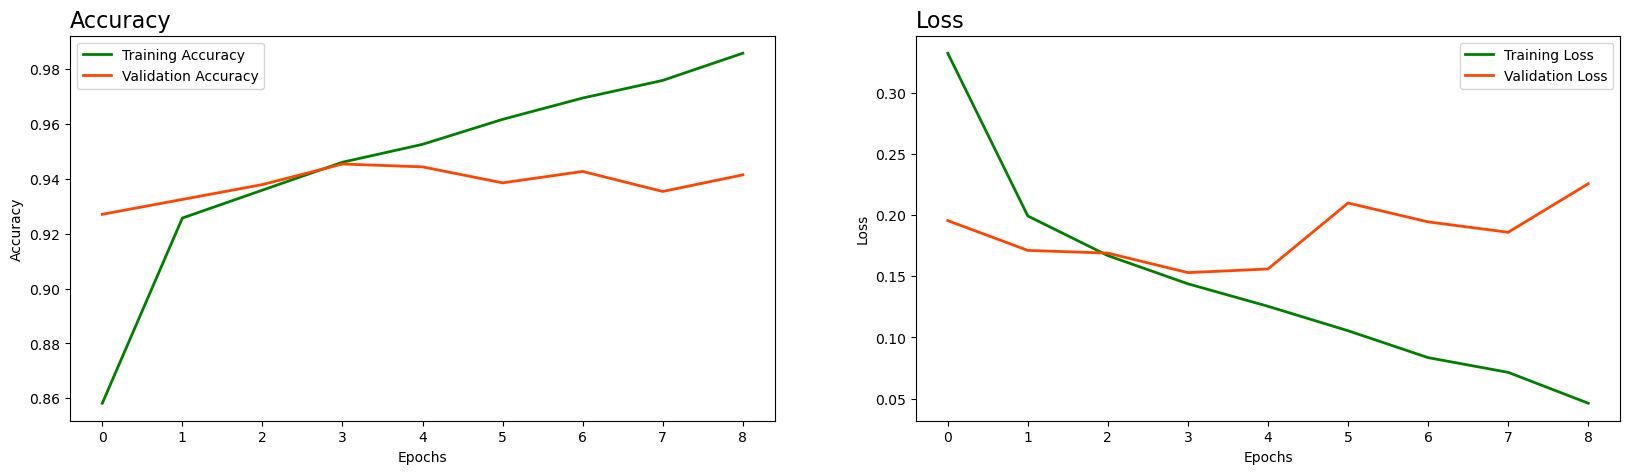

In [19]:
# Method to plot models accuracy/loss
def plot_history(history):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_history(history)

In [20]:
from sklearn import metrics
predictions = bigru_model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1140
           1       0.95      0.96      0.96      2860

    accuracy                           0.94      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.94      0.94      0.94      4000



# **Model Training:Bidirectional LSTM - Concatenation**

In [21]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze GloVe embeddings (set True for fine-tuning)
)(input_layer)

# First Bidirectional LSTM Layer (returning sequences)
bilstm_layer_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Second Bidirectional LSTM Layer (last layer outputs a single vector)
bilstm_layer_2 = Bidirectional(LSTM(32))(bilstm_layer_1)

# Fully connected layer
dense_layer = Dense(64, activation='relu')(bilstm_layer_2)
dropout_layer = Dropout(0.5)(dense_layer)  # Dropout to reduce overfitting
output_layer = Dense(1, activation='sigmoid')(dropout_layer)  # Binary classification output

# Define the Functional model
blstmc = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
blstmc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
blstmc.summary()

C:\Users\hankc\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,130,021 (8.13 MB)

 Trainable params: 129,921 (507.50 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

<h1 style="font-size:20px; line-height:1.5; padding:10px;">
<b>Stop training when a monitored metric has stopped improving
</b>
</h>

In [22]:
from keras.callbacks import EarlyStopping
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = blstmc.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.7948 - loss: 0.4415 - val_accuracy: 0.9140 - val_loss: 0.2190
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9089 - loss: 0.2417 - val_accuracy: 0.9294 - val_loss: 0.1915
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9193 - loss: 0.2063 - val_accuracy: 0.9331 - val_loss: 0.1822
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.9388 - loss: 0.1677 - val_accuracy: 0.9429 - val_loss: 0.1610
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9395 - loss: 0.1618 - val_accuracy: 0.9417 - val_loss: 0.1692
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.9498 - loss: 0.1383 - val_accuracy: 0.9429 - val_loss: 0.1601
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.9580 - loss: 0.1105 - val_accuracy: 0.9477 - val_loss: 0.1546
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.9600 - loss: 0.1064 - 

# **Model Evaluation**

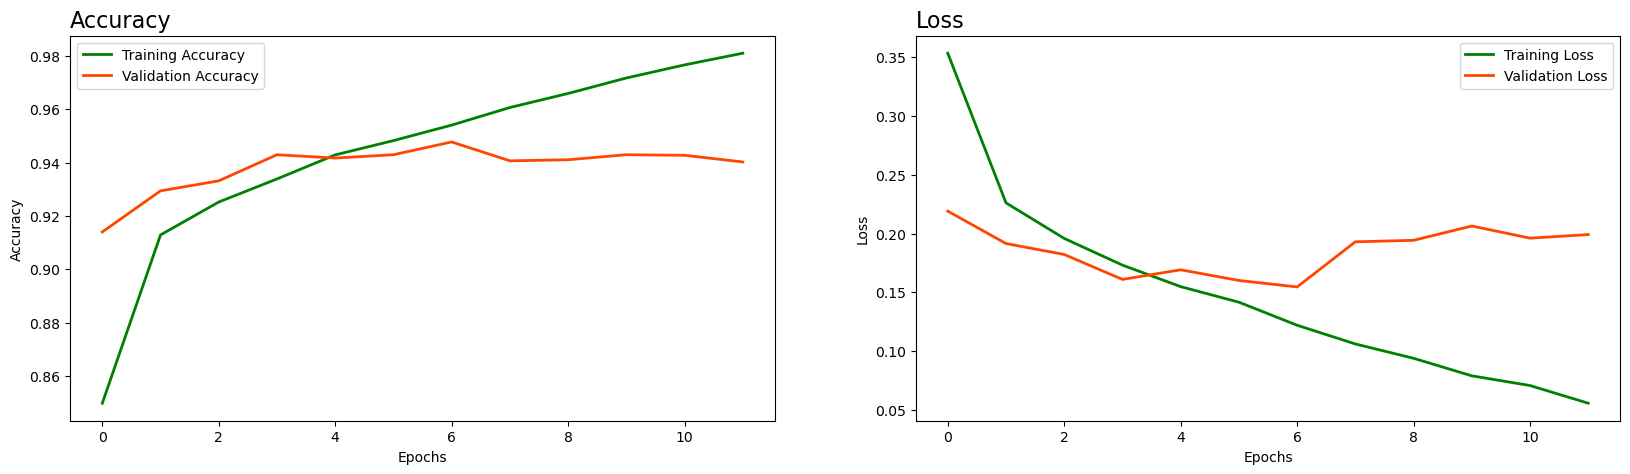

In [23]:
# Method to plot models accuracy/loss
def plot_history(history):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_history(history)

In [24]:
predictions = blstmc.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1140
           1       0.96      0.96      0.96      2860

    accuracy                           0.94      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.94      0.94      0.94      4000

